In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession,Window
import pyspark.sql.functions as F
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler

initial_path = 'C:/Users/Mateus Santos Rochas/Desktop/Estudos/07. Doutorado - Matemática aplicada/Pesquisa/Dados R2'
bronze_path = os.path.join(initial_path,'1. bronze')
prata_path = os.path.join(initial_path,'2. prata')
ouro_path = os.path.join(initial_path,'3. ouro')

spark = SparkSession.builder.appName("Mateus") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.sql.files.maxPartitionBytes", "128MB") \
    .config("spark.sql.files.openCostInBytes", "4MB")  \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.driver.memory", "16g")  \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "4")  \
    .getOrCreate()

conn = duckdb.connect('r2_prata.duckdb')
conn.execute("ATTACH 'r2_ouro.duckdb' AS r2_ouro")


def sql(query,conn=conn):
    return conn.execute(query).fetch_df()

def plot_feature_importance(reg,palette="crest_r"):
    g = sns.barplot(data=pd.DataFrame({"Variável":reg.feature_names_in_,"Importância":reg.feature_importances_}).sort_values('Importância',ascending=False).iloc[:10],x="Variável",y="Importância",hue="Variável",palette=palette)
    plt.xticks(rotation=90)
    plt.grid()
    g.set_axisbelow(True)
    return g
    
show_tables_prata_query = """ SELECT DISTINCT table_name FROM information_schema.tables WHERE table_catalog = 'r2_prata' """

show_tables_ouro_query = """ SELECT DISTINCT table_name FROM information_schema.tables WHERE table_catalog = 'r2_ouro' """

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from metrics import MAE, RMSE, R2_DET,PSC,PSC_A,PCC_A,PMC_A
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Obtendo Datasets

## Apenas Estações

In [3]:
n_estacoes_vizinhas = 4
abt_apenas_estacoes = sql(
"""
SELECT 
    MONTH(CAST(dt_medicao AS DATE)) AS dt_mes_medicao
    ,YEAR(CAST(dt_medicao AS DATE)) AS dt_ano_precipitacao
    ,CASE
        WHEN MONTH(CAST(dt_medicao AS DATE)) IN (11,12,1,2,3) THEN 1
        ELSE 0
    END AS fl_mes_chuvoso
    ,lat_estacao
    ,lon_estacao
    ,vl_temperatura_minima
    ,vl_temperatura_media
    ,vl_temperatura_maxima
    ,vl_umidade_relativa_minima
    ,vl_umidade_relativa_media
    ,vl_precipitacao_vizinha_1
    ,vl_precipitacao_vizinha_2
    ,vl_precipitacao_vizinha_3
    ,vl_precipitacao_vizinha_4
    ,vl_precipitacao_vizinha_5
    ,vl_precipitacao_vizinha_6
    ,vl_precipitacao_vizinha_7
    ,vl_precipitacao_vizinha_8
    ,vl_precipitacao_vizinha_9
    ,vl_precipitacao_vizinha_10
    ,vl_precipitacao_vizinha_11
    ,vl_precipitacao_vizinha_12
    ,vl_precipitacao
FROM r2_ouro.ABT_satelite_all

WHERE 1=1
    AND YEAR(CAST(dt_medicao AS DATE)) >= 2010
    AND vl_precipitacao>=0
    AND vl_precipitacao<=51
""")

abt_apenas_estacoes = abt_apenas_estacoes.drop([f'vl_precipitacao_vizinha_{i}' for i in range(n_estacoes_vizinhas+1,13)],axis=1)
abt_apenas_estacoes_dropna = abt_apenas_estacoes.dropna()

In [4]:
X_est,y_est = abt_apenas_estacoes.drop('vl_precipitacao',axis=1),abt_apenas_estacoes['vl_precipitacao']
X_est_train,X_est_test,y_est_train,y_est_test = train_test_split(X_est,y_est,test_size=0.3,random_state=42)

X_est_dropna,y_est_dropna = abt_apenas_estacoes_dropna.drop('vl_precipitacao',axis=1),abt_apenas_estacoes_dropna['vl_precipitacao']
X_est_dropna_train,X_est_dropna_test,y_est_dropna_train,y_est_dropna_test = train_test_split(X_est_dropna,y_est_dropna,test_size=0.3,random_state=42)

## Estações e Satélites

In [5]:
n_estacoes_vizinhas = 4
abt_estacoes_satelite = sql(
"""
SELECT
    MONTH(CAST(dt_medicao AS DATE)) AS dt_mes_medicao
    ,YEAR(CAST(dt_medicao AS DATE)) AS dt_ano_precipitacao
    ,CASE
        WHEN MONTH(CAST(dt_medicao AS DATE)) IN (11,12,1,2,3) THEN 1
        ELSE 0
    END AS fl_mes_chuvoso
    ,lat_estacao
    ,lon_estacao
    ,vl_temperatura_minima
    ,vl_temperatura_media
    ,vl_temperatura_maxima
    ,vl_umidade_relativa_minima
    ,vl_umidade_relativa_media
    ,vl_precipitacao_vizinha_1
    ,vl_precipitacao_vizinha_2
    ,vl_precipitacao_vizinha_3
    ,vl_precipitacao_vizinha_4
    ,vl_precipitacao_vizinha_5
    ,vl_precipitacao_vizinha_6
    ,vl_precipitacao_vizinha_7
    ,vl_precipitacao_vizinha_8
    ,vl_precipitacao_vizinha_9
    ,vl_precipitacao_vizinha_10
    ,vl_precipitacao_vizinha_11
    ,vl_precipitacao_vizinha_12
    ,vl_precipitacao
    --,vl_precipitacao_AgCFSR
    --,vl_umidade_relativa_maxima_AgCFSR
    --,vl_radiacao_solar_AgCFSR
    --,vl_temperatura_media_AgCFSR
    --,vl_temperatura_maxima_AgCFSR
    --,vl_temperatura_minima_AgCFSR
    --,vl_vento_velocidade_AgCFSR
    ,vl_radiacao_solar_ceu_total_POWER
    ,vl_precipitacao_total_corrigido_POWER
    ,vl_pressao_superficie_POWER
    ,vl_umidade_relativa_2m_POWER
    ,vl_temperatura_maxima_2m_POWER
    ,vl_temperatura_minima_2m_POWER
    ,vl_temperatura_media_2m_POWER
    ,vl_temperatura_orvalho_2m_POWER
    ,vl_direcao_vento_2m_POWER
    ,vl_direcao_vento_10m_POWER
    ,vl_maxima_vento_2m_POWER
    ,vl_ws2m_POWER
    ,vl_maxima_vento_10m_POWER
    ,vl_vento_10m_POWER
    ,vl_precipitacao_GPM_Late_Run
    --,vl_irradiancia_GL
    ,vl_precipitacao_CPC
    ,vl_precipitacao_GPM_Final_Run
    --,vl_precipitacao_AgMERRA
    --,vl_umidade_relativa_maxima_AgMERRA
    --,vl_radiacao_solar_AgMERRA
    --,vl_temperatura_media_AgMERRA
    --,vl_temperatura_maxima_AgMERRA
    --,vl_temperatura_minima_AgMERRA
    --,vl_vento_velocidade_AgMERRA
    --,vl_precipitacao_TRMM
    ,vl_precipitacao_CHIRPS
    ,vl_precipitacao_PERSIANN_CDR
FROM r2_ouro.ABT_satelite_all
WHERE 1=1
    AND YEAR(CAST(dt_medicao AS DATE)) >= 2010
    AND vl_precipitacao>=0
    AND vl_precipitacao<=51
"""
)
abt_estacoes_satelite = abt_estacoes_satelite.drop([f'vl_precipitacao_vizinha_{i}' for i in range(n_estacoes_vizinhas+1,13)],axis=1)
abt_estacoes_satelite_dropna = abt_estacoes_satelite.dropna().copy()

In [6]:
X_all,y_all = abt_estacoes_satelite.drop('vl_precipitacao',axis=1),abt_estacoes_satelite['vl_precipitacao']
X_all_train,X_all_test,y_all_train,y_all_test = train_test_split(X_all,y_all,test_size=0.3,random_state=42)

X_all_dropna,y_all_dropna = abt_estacoes_satelite_dropna.drop('vl_precipitacao',axis=1),abt_estacoes_satelite_dropna['vl_precipitacao']
X_all_dropna_train,X_all_dropna_test,y_all_dropna_train,y_all_dropna_test = train_test_split(X_all_dropna,y_all_dropna,test_size=0.3,random_state=42)


# Busca de Hiperparâmetros

## Apenas Estações

### Random Forest

In [8]:
rf = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],  # Número de árvores
    'max_features': ['sqrt', 'log2', None],  # Número máximo de features por split
    'max_depth': [10, 20, 30, 50],  # Profundidade máxima
    'min_samples_split': [2,5,10, 20, 50],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [2,5, 10, 20], # Número mínimo de amostras em um nó folha
    'bootstrap': [True, False]  # Amostragem com ou sem reposição
}

# Configurar RandomizedSearchCV
rf_random = GridSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,  # Número de combinações a testar
    cv=3,  # Número de folds para validação cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'  
)

# Ajustar o modelo
rf_random.fit(X_est_train, y_est_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         1000]},
                   random_state=42, scoring='r2', verbose=2)

In [ ]:
# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(rf_random.best_params_)

# Avaliar o modelo
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_est_test)
r2 = R2_DET(y_est_test, y_pred)
print(f"R2 de determinação no conjunto de teste: {r2:.4f}")

Melhores hiperparâmetros encontrados:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
R2 de determinação no conjunto de teste: 0.4162


### SVR

In [45]:
from sklearn.preprocessing import StandardScaler

svr = SVR(C=0.6,epsilon=0.2,gamma='auto')

param_distributions = {
    'C': [0.5,0.6,0.7],  # Variação em escala logarítmica
    'epsilon': [0.1, 0.2, 0.3],  # Margem de tolerância
    'kernel': ['linear', 'rbf','poly'],  # Kernels mais comuns para SVR
    'gamma': ['scale', 'auto']  # Definir gamma automaticamente ou em escala
}
scaler = StandardScaler().fit(X_est_dropna_train)
svr_random = GridSearchCV(
    estimator=svr,
    param_grid =param_distributions,
    scoring='r2',
    verbose=3,
    n_jobs=4
)

svr_random.fit(scaler.transform(X_est_dropna_train.iloc[:25000]),y_est_dropna_train.iloc[:25000])

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=SVR(C=0.6, epsilon=0.2, gamma='auto'), n_jobs=4,
             param_grid={'C': [0.5, 0.6, 0.7], 'epsilon': [0.1, 0.2, 0.3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='r2', verbose=3)

In [48]:
print("Melhores hiperparâmetros encontrados:")
print(svr_random.best_params_)

Melhores hiperparâmetros encontrados:
{'C': 0.7, 'epsilon': 0.3, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
best_svr = svr_random.best_estimator_
y_pred = best_svr.predict(scaler.transform(X_est_dropna_test))
r2 = R2_DET(y_est_dropna_test, y_pred)
print(f"R² no conjunto de teste: {r2:.4f}")

# 0.3800

R² no conjunto de teste: 0.3421


### XGBoost

In [43]:
xgb = XGBRegressor(random_state=42, tree_method='hist')  # tree_method otimizado para grandes datasets

# Definir o espaço de busca
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0.01, 0.1, 1, 10,20,50]  # L2 regularization
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=30,  # Número de combinações a testar
    cv=3,  # Validação cruzada 3-fold
    scoring='r2',  # Usar a função R2_DETERMINACAO
    verbose=4,
    random_state=42,
    n_jobs=-1
)

# Ajustar o modelo
xgb_random.fit(X_est_train, y_est_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 10, 15],
                                        'n_estimators': [100, 200, 300, 400],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0.01, 0.1, 1, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=4)

In [44]:
print("Melhores hiperparâmetros encontrados:")
print(xgb_random.best_params_)

# Avaliar o modelo
best_xgb = xgb_random.best_estimator_
y_pred = best_xgb.predict(X_est_test)
r2 = R2_DET(y_est_test, y_pred)
print(f"R² no conjunto de teste: {r2:.4f}")

Melhores hiperparâmetros encontrados:
{'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
R² no conjunto de teste: 0.4636


### MLP Regressor

In [54]:
mlp = MLPRegressor(max_iter=2000, random_state=42)

# Definir o espaço de busca mais enxuto para GridSearch
param_grid = {
    'hidden_layer_sizes': [
        (10,), (50,), (100,), (200,), (500,),  # Camada única
        (50, 10), (100, 50), (200, 100), (500, 100),  # Duas camadas
        (100, 50, 10), (200, 100, 50), (500, 200, 100),  # Três camadas
        (50, 50, 50), (100, 100, 50), (200, 100, 50, 10), (500, 100, 50, 10)  # Mais camadas
    ],
    'activation': ['relu', 'logistic'],  # Funções de ativação
    'solver': ['adam'],  # Usar apenas o solver Adam para reduzir o grid
    'alpha': [0.0001, 0.001],  # Regularização L2
    'learning_rate': ['constant', 'adaptive'],  # Taxa de aprendizado
    'learning_rate_init': [0.001, 0.01]  # Taxa de aprendizado inicial
}

# Configurar GridSearchCV
mlp_grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,  # Validação cruzada 3-fold
    scoring='r2',  # Usar a métrica personalizada
    verbose=2,
    n_jobs=-1
)

# Ajustar o modelo
mlp_grid.fit(X_est_dropna_train, y_est_dropna_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(10,), (50,), (100,), (200,),
                                                (500,), (50, 10), (100, 50),
                                                (200, 100), (500, 100),
                                                (100, 50, 10), (200, 100, 50),
                                                (500, 200, 100), (50, 50, 50),
                                                (100, 100, 50),
                                                (200, 100, 50, 10),
                                                (500, 100, 50, 10)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.001, 0.01],
                         'solver': ['adam']},
             scoring='r2', verbose=2)

In [55]:
# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(mlp_grid.best_params_)

# Avaliar o modelo
best_mlp = mlp_grid.best_estimator_
y_pred = best_mlp.predict(X_est_dropna_test)
r2 = R2_DET(y_est_dropna_test, y_pred)
print(f"R² no conjunto de teste: {r2:.4f}")

Melhores hiperparâmetros encontrados:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}
R² no conjunto de teste: 0.4423


## Estações e Satélites

### Random Forest

In [81]:
rf = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],  # Número de árvores
    'max_features': ['sqrt', 'log2', None],  # Número máximo de features por split
    'max_depth': [10, 20, 30, 50],  # Profundidade máxima
    'min_samples_split': [2,5,10, 20, 50],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [2,5, 10, 20], # Número mínimo de amostras em um nó folha
    'bootstrap': [True, False]  # Amostragem com ou sem reposição
}

# Configurar RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,  # Número de combinações a testar
    cv=3,  # Número de folds para validação cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'  
)

# Ajustar o modelo
rf_random.fit(X_all_train, y_all_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         1000]},
                   random_state=42, scoring='r2', verbose=2)

In [82]:
# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(rf_random.best_params_)

# Avaliar o modelo
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_all_test)
r2 = R2_DET(y_all_test, y_pred)
print(f"R2 de determinação no conjunto de teste: {r2:.4f}")

# antes: 0.4719

Melhores hiperparâmetros encontrados:
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
R2 de determinação no conjunto de teste: 0.5371


### SVR

In [56]:
from sklearn.preprocessing import StandardScaler

svr = SVR(C=0.6,epsilon=0.2,gamma='auto')

param_distributions = {
    'C': [0.5,0.6,0.7],  # Variação em escala logarítmica
    'epsilon': [0.1, 0.2, 0.3],  # Margem de tolerância
    'kernel': ['linear', 'rbf','poly'],  # Kernels mais comuns para SVR
    'gamma': ['scale', 'auto']  # Definir gamma automaticamente ou em escala
}
scaler = StandardScaler().fit(X_all_dropna_train)
svr_random = GridSearchCV(
    estimator=svr,
    param_grid =param_distributions,
    scoring='r2',
    verbose=3,
    n_jobs=4
)

svr_random.fit(scaler.transform(X_all_dropna_train.iloc[:25000]),y_all_dropna_train.iloc[:25000])

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=SVR(C=0.6, epsilon=0.2, gamma='auto'), n_jobs=4,
             param_grid={'C': [0.5, 0.6, 0.7], 'epsilon': [0.1, 0.2, 0.3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='r2', verbose=3)

In [66]:
print("Melhores hiperparâmetros encontrados:")
print(svr_random.best_params_)

best_svr = svr_random.best_estimator_
y_pred = best_svr.predict(scaler.transform(X_all_dropna_test))
r2 = R2_DET(y_all_dropna_test, y_pred)
print(f"R² no conjunto de teste: {r2:.4f}")

Melhores hiperparâmetros encontrados:
{'C': 0.7, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'linear'}
R² no conjunto de teste: 0.4447


### XGBoost

In [11]:
xgb = XGBRegressor(random_state=42, tree_method='hist')  # tree_method otimizado para grandes datasets

# Definir o espaço de busca
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0.01, 0.1, 1, 10,20,50]  # L2 regularization
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=30,  # Número de combinações a testar
    cv=3,  # Validação cruzada 3-fold
    scoring='r2',  # Usar a função R2_DETERMINACAO
    verbose=4,
    random_state=42,
    n_jobs=-1
)

# Ajustar o modelo
xgb_random.fit(X_all_train, y_all_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 10, 15],
                                        'n_estimators': [100, 200, 300, 400],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0.01, 0.1, 1, 10, 20,
                                                       50],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=4)

In [14]:
print("Melhores hiperparâmetros encontrados:")
print(xgb_random.best_params_)

# Avaliar o modelo
best_xgb = xgb_random.best_estimator_
y_pred = best_xgb.predict(X_all_test)
r2 = R2_DET(y_all_test, y_pred)
print(f"R² no conjunto de teste: {r2:.4f}")

Melhores hiperparâmetros encontrados:
{'subsample': 0.6, 'reg_lambda': 50, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
R² no conjunto de teste: 0.5695


### MLP Regressor

In [69]:
from sklearn.preprocessing import StandardScaler

mlp = MLPRegressor(early_stopping=True, random_state=42)

# Definir o espaço de busca mais enxuto para GridSearch
param_grid = {
    'hidden_layer_sizes': [
        (10,), (50,), (100,), (200,), (500,),  # Camada única
        (50, 10), (100, 50), (200, 100), (500, 100),  # Duas camadas
        (100, 50, 10), (200, 100, 50), (500, 200, 100),  # Três camadas
        (50, 50, 50), (100, 100, 50), (200, 100, 50, 10), (500, 100, 50, 10)  # Mais camadas
    ],
    'activation': ['relu', 'logistic'],  # Funções de ativação
    'solver': ['adam'],  # Usar apenas o solver Adam para reduzir o grid
    'alpha': [0.0001, 0.001],  # Regularização L2
    'learning_rate': ['constant', 'adaptive'],  # Taxa de aprendizado
    'learning_rate_init': [0.001, 0.01]  # Taxa de aprendizado inicial
}

# Configurar GridSearchCV
mlp_grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

mlp_grid.fit(scaler.transform(X_all_dropna_train.iloc[:25000]),y_all_dropna_train.iloc[:25000])

Fitting 3 folds for each of 256 candidates, totalling 768 fits


GridSearchCV(cv=3, estimator=MLPRegressor(early_stopping=True, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(10,), (50,), (100,), (200,),
                                                (500,), (50, 10), (100, 50),
                                                (200, 100), (500, 100),
                                                (100, 50, 10), (200, 100, 50),
                                                (500, 200, 100), (50, 50, 50),
                                                (100, 100, 50),
                                                (200, 100, 50, 10),
                                                (500, 100, 50, 10)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.001, 0.01],
                         'solver': ['adam']},
             scoring='r2', verbose=2)

In [70]:
print("Melhores hiperparâmetros encontrados:")
print(mlp_grid.best_params_)

best_mlp = mlp_grid.best_estimator_
y_pred = best_mlp.predict(scaler.transform(X_all_dropna_test))
r2 = R2_DET(y_all_dropna_test, y_pred)
print(f"R² no conjunto de teste: {r2:.4f}")

Melhores hiperparâmetros encontrados:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}
R² no conjunto de teste: 0.5146


# Rodando modelo

## Apenas Estações

### Random Forest

In [7]:
rf_reg = RandomForestRegressor(n_estimators=200,min_samples_split=10,min_samples_leaf=2,max_features='sqrt',max_depth=50,bootstrap=True)
rf_reg.fit(X_est_train, y_est_train)
y_pred = rf_reg.predict(X_est_test)

In [8]:
print(f"MAE: {MAE(y_est_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_est_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_est_test,y_pred):.3f}")
print(f"PSC: {PSC(y_est_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_est_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_est_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_est_test,y_pred,5,20):.2f}%")

MAE: 2.665
RMSE: 5.593
R2 DET: 0.427
PSC: 0.12%
PSC_A(0.5): 62.34%
PCC_A(0.5): 16.38%
PMC_A(5,20): 8.39%


### SVR

In [10]:
svr = SVR(C=0.7,epsilon=0.3,gamma='auto',kernel='rbf')
svr.fit(X_est_dropna_train,y_est_dropna_train)
y_pred = svr.predict(X_est_dropna_test)

In [11]:
print(f"MAE: {MAE(y_est_dropna_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_est_dropna_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_est_dropna_test,y_pred):.3f}")
print(f"PSC: {PSC(y_est_dropna_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_est_dropna_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_est_dropna_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_est_dropna_test,y_pred,5,20):.2f}%")

MAE: 2.744
RMSE: 7.326
R2 DET: -0.029
PSC: 0.00%
PSC_A(0.5): 72.00%
PCC_A(0.5): 24.96%
PMC_A(5,20): 0.00%


### XGBoost

In [14]:
xgb_reg = XGBRegressor(tree_method='hist',subsample=1,reg_lambda=10,reg_alpha=0,n_estimators=200,max_depth=10,learning_rate=0.1,colsample_bytree=0.8)
xgb_reg.fit(X_est_train, y_est_train)
y_pred = xgb_reg.predict(X_est_test)

In [15]:
print(f"MAE: {MAE(y_est_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_est_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_est_test,y_pred):.3f}")
print(f"PSC: {PSC(y_est_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_est_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_est_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_est_test,y_pred,5,20):.2f}%")

MAE: 2.589
RMSE: 5.541
R2 DET: 0.437
PSC: 0.00%
PSC_A(0.5): 63.86%
PCC_A(0.5): 17.16%
PMC_A(5,20): 10.12%


### MLP Regressor

In [17]:
mlp_reg = MLPRegressor(max_iter=2000,activation='relu',alpha=0.0001,hidden_layer_sizes=(100,100,50),learning_rate='constant',learning_rate_init=0.001,solver='adam')
mlp_reg.fit(X_est_dropna_train,y_est_dropna_train)
y_pred = mlp_reg.predict(X_est_dropna_test)

In [20]:
print(f"MAE: {MAE(y_est_dropna_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_est_dropna_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_est_dropna_test,y_pred):.3f}")
print(f"PSC: {PSC(y_est_dropna_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_est_dropna_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_est_dropna_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_est_dropna_test,y_pred,5,20):.2f}%")

MAE: 2.273
RMSE: 5.542
R2 DET: 0.411
PSC: 0.00%
PSC_A(0.5): 90.37%
PCC_A(0.5): 24.61%
PMC_A(5,20): 8.70%


## Estações + Satélite

### Random Forest

In [7]:
rf_reg = RandomForestRegressor(n_estimators=200,min_samples_split=20,min_samples_leaf=5,max_features=None,max_depth=30,bootstrap=True)
rf_reg.fit(X_all_train, y_all_train)
y_pred = rf_reg.predict(X_all_test)

In [8]:
print(f"MAE: {MAE(y_all_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_all_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_all_test,y_pred):.3f}")
print(f"PSC: {PSC(y_all_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_all_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_all_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_all_test,y_pred,5,20):.2f}%")

MAE: 2.225
RMSE: 5.016
R2 DET: 0.540
PSC: 0.00%
PSC_A(0.5): 76.44%
PCC_A(0.5): 19.83%
PMC_A(5,20): 16.42%


In [55]:
def plot_feature_importance(reg,palette="crest_r"):
    g = sns.barplot(data=pd.DataFrame({"Variável":reg.feature_names_in_,"Importância":reg.feature_importances_}).sort_values('Importância',ascending=False).iloc[:10],x="Variável",y="Importância",hue="Variável",palette=palette)
    plt.xticks(rotation=45,ha='right')
    g.set_xlabel("")
    plt.grid()
    g.set_axisbelow(True)
    return g

Text(0.5, 1.0, 'Importância de variáveis do modelo integrado: Random Forest')

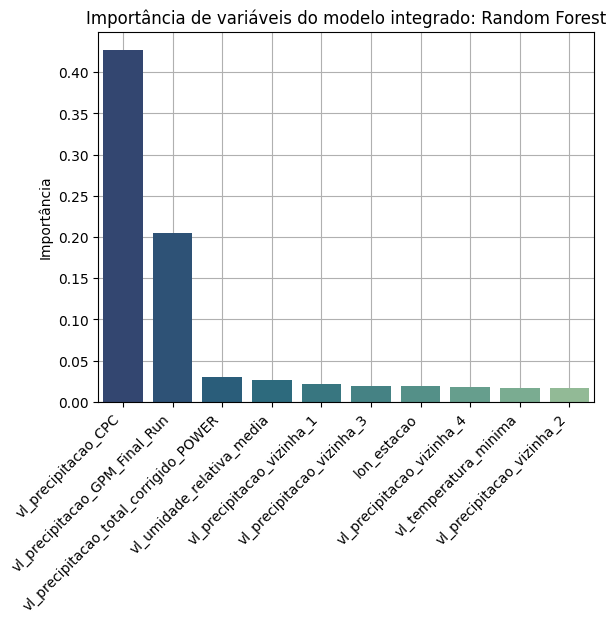

In [56]:
plot_feature_importance(rf_reg)
plt.title("Importância de variáveis do modelo integrado: Random Forest")

### SVR

In [9]:
svr = SVR(C=0.7,epsilon=0.3,gamma='scale',kernel='linear')
scaler = StandardScaler().fit(X_all_dropna_train)
svr.fit(scaler.transform(X_all_dropna_train),y_all_dropna_train)
y_pred = svr.predict(scaler.transform(X_all_dropna_test))

In [10]:
print(f"MAE: {MAE(y_all_dropna_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_all_dropna_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_all_dropna_test,y_pred):.3f}")
print(f"PSC: {PSC(y_all_dropna_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_all_dropna_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_all_dropna_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_all_dropna_test,y_pred,5,20):.2f}%")

MAE: 2.132
RMSE: 5.306
R2 DET: 0.450
PSC: 0.00%
PSC_A(0.5): 84.71%
PCC_A(0.5): 22.13%
PMC_A(5,20): 5.22%


### XGBoost

In [11]:
xgb = XGBRegressor(random_state=42, tree_method='hist',subsample=0.6,reg_lambda=50,reg_alpha=1,n_estimators=300,max_depth=10,learning_rate=0.1,colsample_bytree=1)
xgb.fit(X_all_train,y_all_train)
y_pred = xgb.predict(X_all_test)

In [12]:
print(f"MAE: {MAE(y_all_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_all_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_all_test,y_pred):.3f}")
print(f"PSC: {PSC(y_all_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_all_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_all_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_all_test,y_pred,5,20):.2f}%")

MAE: 2.110
RMSE: 4.849
R2 DET: 0.570
PSC: 0.00%
PSC_A(0.5): 78.46%
PCC_A(0.5): 20.80%
PMC_A(5,20): 18.60%


Text(0.5, 1.0, 'Importância de variáveis do modelo integrado: XGBoost')

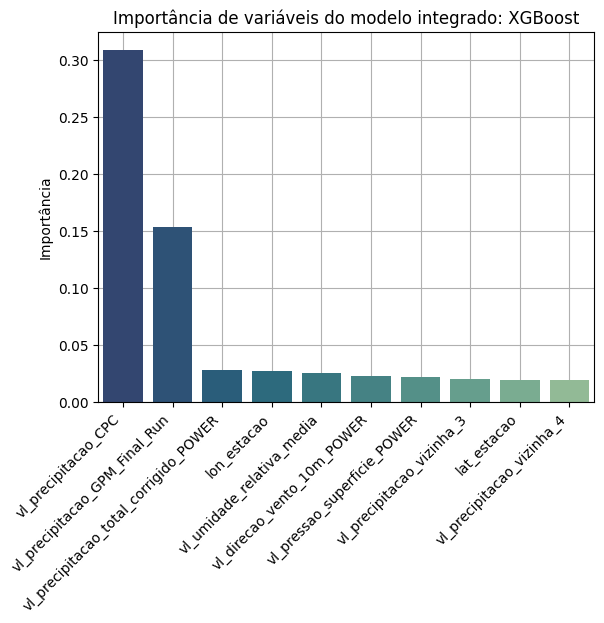

In [57]:
plot_feature_importance(xgb)
plt.title("Importância de variáveis do modelo integrado: XGBoost")

### MLP Regressor

In [16]:
mlp_reg = MLPRegressor(early_stopping=True,activation='relu',alpha=0.001,hidden_layer_sizes=(200,),learning_rate='constant',learning_rate_init=0.001,solver='adam')
mlp_reg.fit(scaler.transform(X_all_dropna_train),y_all_dropna_train)
y_pred = mlp_reg.predict(scaler.transform(X_all_dropna_test))

In [17]:
print(f"MAE: {MAE(y_all_dropna_test,y_pred):.3f}")
print(f"RMSE: {RMSE(y_all_dropna_test,y_pred):.3f}")
print(f"R2 DET: {R2_DET(y_all_dropna_test,y_pred):.3f}")
print(f"PSC: {PSC(y_all_dropna_test,y_pred):.2f}%")
print(f"PSC_A(0.5): {PSC_A(y_all_dropna_test,y_pred,0.5):.2f}%")
print(f"PCC_A(0.5): {PCC_A(y_all_dropna_test,y_pred,0.5):.2f}%")
print(f"PMC_A(5,20): {PMC_A(y_all_dropna_test,y_pred,5,20):.2f}%")

MAE: 2.316
RMSE: 4.897
R2 DET: 0.532
PSC: 0.00%
PSC_A(0.5): 68.89%
PCC_A(0.5): 16.01%
PMC_A(5,20): 16.28%
